# Evaluating the sample dataset

This demo jupyter notebook reads and runs an evaluation on a sample dataset included in UVal package inside the `data` folder.  
Here is how it is organized:

`data `  
&nbsp;&nbsp;├── `datasplit` <font color='green'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;# The datasplit file in YAML format  </font>  
&nbsp;&nbsp;└── `hdf5` <font color='green'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;# a bunch of HDF5 files created following the instructions below</font>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── `detections` <font color='green'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;# HDF5 files containing detection ROIs, classes and scores </font>  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── `raw` <font color='green'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;# HDF5 files containing groundtruth ROIs and classes</font>  
    
<font color='red'>Note that</font> the sample dataset is generated only for test purposes and does not contain accurate evaluation results.

### UVal HDF5 data format
As described in the `src/uval/utils/hdf5_format.py` file the proposed HDF5 format in UVal follows these naming coventions:
1. <b>IMAGENAME<font color='blue'>.det.h5</font></b><br /> files containing the detection results and metadata of the images:
  * /detections/#  {class_name, roi_shape, roi_start, score  
  * /file_meta  {det_version, dt_generated, host_name, user_name}  
  * /volume_meta  {file_md5, full_shape, id, is_cropped, roi_shape, roi_start}    
2. <b>IMAGENAME<font color='blue'>.gt.h5</font></b><br /> files containing the groundtruth data and metadata of the image:
  * /groundtruth/%\_label\_# {class_name, roi_shape, roi_start, subclass_name, target_id}
  * /file_meta  {det_version, dt_generated, host_name, user_name}  
  * /volume_meta  {file_md5, full_shape, id, is_cropped, roi_shape, roi_start}  
3. <b>IMAGENAME<font color='blue'>.volcache.h5</font></b><br /> files containing the cache data of the main image's 2D projections and some image metadata:
  * /volume_meta  {file_md5, full_shape, id, is_cropped, roi_shape, roi_start}  
  * /volume_meta/cache {projection_x, projection_y, projection_z}  
4. <b>IMAGENAME<font color='blue'>.voldata.h5</font></b><br /> files containing the 3d volume and the image metadata:
  * /volume_data
  * /volume_meta  {file_md5, full_shape, id, is_cropped, roi_shape, roi_start}  
  
To be able to use UVal for evaluation, the input data must be generated following the abovementioned format and naming conventions. For more mor information regarding the filed types please refer to the documentation in `src/uval/utils/hdf5_format.py` file.

#### In the following, the sample dataset is read and evaluated in a step-by-step manner. Finally, the generated report file in html format along with plots for each detection class is visualized.

------
<font color='red'>Hint:</font> Before running this jupyter document, the `uvalenv` environment must be added as an ipykernel. The `uvalenv Python 3.8` kernel which includes all the required python packages must be selected. This is how to do it:  
  
<code>$ conda install -c anaconda ipykernel  
$ python3 -m ipykernel install --user --name uvalenv --display-name "uvalenv Python 3.8"
</code>  
------

# Importing required functions
#### The following functions are imported from the `uval` package to read and evaluate the data

In [1]:
import os
from uval import get_context, load_datasplit, load_evaulation_files, support_dataset_with_file_paths
from uval import Metrics
from uval.config.config_utils import get_cfg

### Creating evaluation configuration
Conventionally, a YAML config file containing a set of parameters is provided to the pipeline to run each evaluation.  
Here the default config parameters are used by creating an instance of the `Config` class:

In [2]:
cfg = get_cfg()
ctx = get_context(max_workers=2)
cfg.OUTPUT.TITLE = "Sample images evaluation"  # Changing defaults according to src/uval/config/defaults.py

# Reading the sample data
### Reading the datasplit YAML file
The YAML file in the `data` folder contains information about:
- Datasplit subsets
- Image names
- Is image negative ? (containing no threat)
- The images classes

In [3]:
ctx.set_cache_folder(cfg.ENV.CACHE_FOLDER)
with ctx.cached():
    dataset = load_datasplit(cfg.DATA_SPLIT.YAML, cfg.DATA_SPLIT.SUBSET)

### Displaying the data overview
The datasplit is read as `pandas.DataFrame` and can be easily displayed using internal pandas functions.  
For simplicity, we only show <em>20</em> rows of the table:

In [4]:
import pandas
pandas.set_option("display.max_rows", 20)  # set to None displays all the records
dataset.table[["is_negative", "subset", "class_name"]]

is_negative subset class_name
BAGGAGE_20180320_123510_124166_label_1        False  train    firearm
BAGGAGE_20180628_115125_124166_label_1        False  train    firearm
BAGGAGE_20180703_135144_124166_label_1        False  train    firearm
BAGGAGE_20180703_135144_124166_label_2        False  train    firearm
BAGGAGE_20180703_135559_124166_label_1        False  train    firearm
...                                             ...    ...        ...
BAGGAGE_20171205_080727_012345                 True   test   negative
BAGGAGE_20171205_091018_012345                 True   test   negative
BAGGAGE_20171205_101217_012345                 True   test   negative
BAGGAGE_20171206_071346_012345                 True   test   negative
BAGGAGE_20171206_094504_012345                 True   test   negative

[109 rows x 3 columns]

### Loading HDF5 files
The `load_evaulation_files()` function reads the positive and negative HDF5 files belonging to a dataset and splits them into detections and  groundtruth lists:

In [5]:
    hdf5_detections, hdf5_groundtruth, soc_data = load_evaulation_files(cfg.DATA.PATH, dataset=dataset)

### Creating a supported dataset
The `support_dataset_with_file_paths()` function binds the given dataset and the found Hdf5 files:

In [6]:
     supported_dataset = support_dataset_with_file_paths(hdf5_groundtruth, hdf5_detections, soc_data)

           INFO     Starting stage 'support_dataset_with_file_paths'              ]8;id=996211;file://uval/src/uval/stages/stage.py\stage.py]8;;\:19

           INFO     Dataset union statistics:                             ]8;id=538315;file://uval/src/uval/stages/combine_files.py\combine_files.py]8;;\:88
                      GT & DET = 35                                                          
                      GT - DET = 0                                                           
                      DET - GT = 0                                                           
                      DET + GT + SOC  = 85

[14:04:36] INFO     Stage 'support_dataset_with_file_paths' done                  ]8;id=882426;file://uval/src/uval/stages/stage.py\stage.py]8;;\:21

### Initializing the evaluator
An evaluator object is initialized considering the dataset and the requestred metrics in config. Here, the default metrics are being evaluated:

In [7]:
    evaluator = Metrics(supported_dataset, cfg.METRICS, cfg.OUTPUT)

### Running the evaluation
The evaluation is performed to calculate the metric and generate a report. Meanwhile it also:
- Checks if classes in datasplit and provided data match
- Validates the detections and groundtruth regions
- Creates pickle files to speedup the evaluation
- Plots the requested curves

In [8]:
    res = evaluator.evaluate()

In [9]:
    print(str(res).replace(',',',\n'))

{'single_threshold': [{'Single_Recall': 0.8666666666666667,
 'Total Positives': 30.0,
 'Total Negatives': 22.0,
 'Total TP': 18,
 'Total FP': 1,
 'Total FN': 12.0,
 'Total TP soft': 15.152558624744415,
 'Total FP soft': 0.7209414839744568,
 'Total FN soft': 14.847441375255585,
 'AP': 0.8060606060606064,
 'F score': 0.7346938775510204,
 'F score soft': 0.6606236100944244},
 {'Single_Recall': 1.0,
 'Total Positives': 22.0,
 'Total Negatives': 30.0,
 'Total TP': 22,
 'Total FP': 8,
 'Total FN': 0.0,
 'Total TP soft': 20.293060421943665,
 'Total FP soft': 6.645928800106049,
 'Total FN soft': 1.7069395780563354,
 'AP': 0.9151662731208188,
 'F score': 0.8461538461538461,
 'F score soft': 0.8293207826532111}]}


##  Displaying the report
The generated evaluation report containing the calculated metrics and plotted curves are displayed here.  
<font color='brown'>Unfortunately, the images of plots in HTML report cannot be displayed in jupyter notebook, so we display them separately below:</font>

In [10]:
from IPython.core.display import HTML, Image # to visualize HTML
html_report = os.path.join(cfg.OUTPUT.PATH, cfg.OUTPUT.REPORT_FILE)
display(HTML(html_report))

## Loading the generated plot images from disk

In [11]:
import glob
from IPython.core.display import display

#### Displaying 'firearms' plots

'firearm_precision_recall.png'

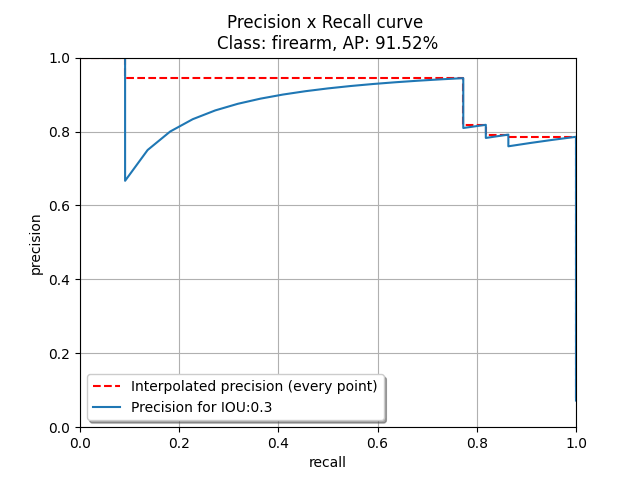

'firearm_roc.png'

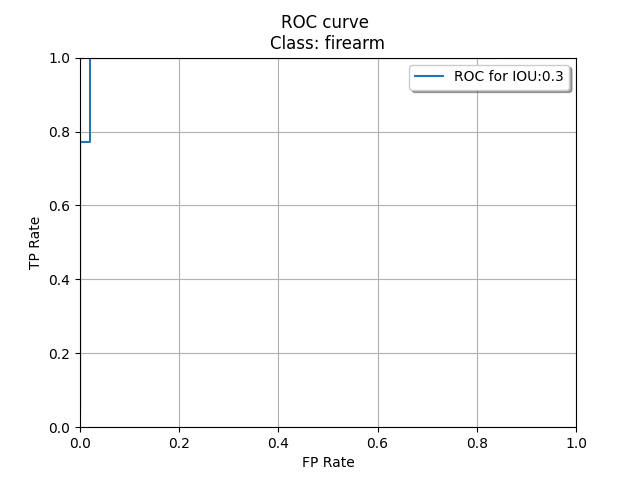

In [12]:
for imageName in sorted(glob.glob(cfg.OUTPUT.PATH + '/firearm*.png')):
    display(os.path.basename(imageName), Image(imageName))    

### Displaying 'knife' plots

'knife_precision_recall.png'

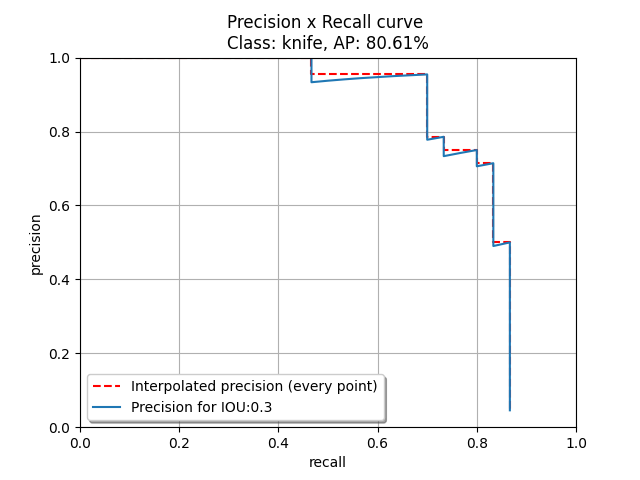

'knife_roc.png'

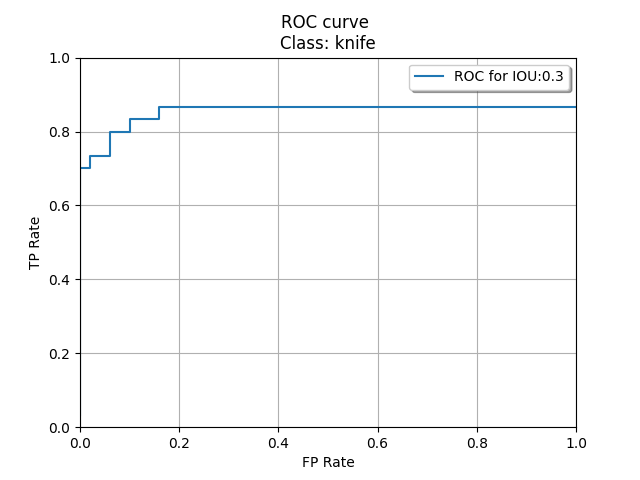

In [13]:
for imageName in sorted(glob.glob(cfg.OUTPUT.PATH + '/knife*.png')):
    display(os.path.basename(imageName), Image(imageName))    